檔名:(您的學號)_hw3.ipynb

一.載入資料集:https://www.kaggle.com/datasets/lara311/flowers-five-classes (10分)

In [1]:
import kagglehub
from pathlib import Path
import torch
from torchvision import datasets, models
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download the dataset and load it
path = kagglehub.dataset_download("lara311/flowers-five-classes")
dataset_dir = Path(path) / "train"
dataset = datasets.ImageFolder(dataset_dir)
dataset_df = pd.DataFrame(dataset.samples, columns=["path", "label"])

二.視覺化每個類別的第一張圖和各自的真實標籤(10分)

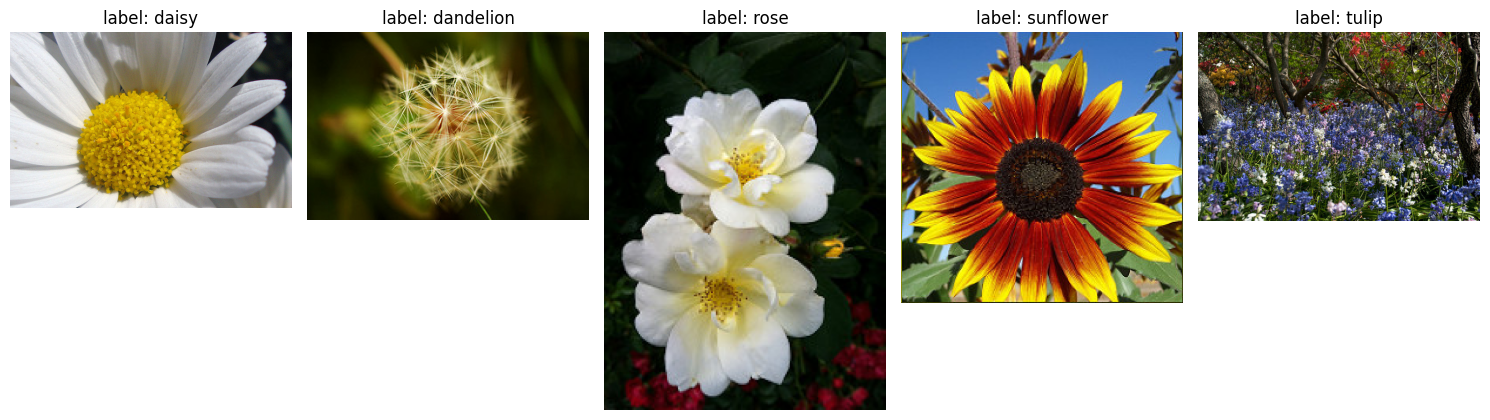

In [9]:
fig, axes = plt.subplots(1, len(dataset.classes), figsize=(15, 15))

for i, class_name in enumerate(dataset.classes):
  df = dataset_df[dataset_df["label"] == i]
  image_path = df.iloc[0]["path"]
  image = Image.open(image_path)
  axes[i].imshow(image)
  axes[i].set_title(f'label: {class_name}')
  axes[i].axis('off')
  axes[i].set_anchor('N')
  
fig.align_titles()
plt.tight_layout()
plt.show()

三.使用resnet18模型推論每種類別的前五張圖片,顯示出圖片、真實標籤和預測標籤(10分)

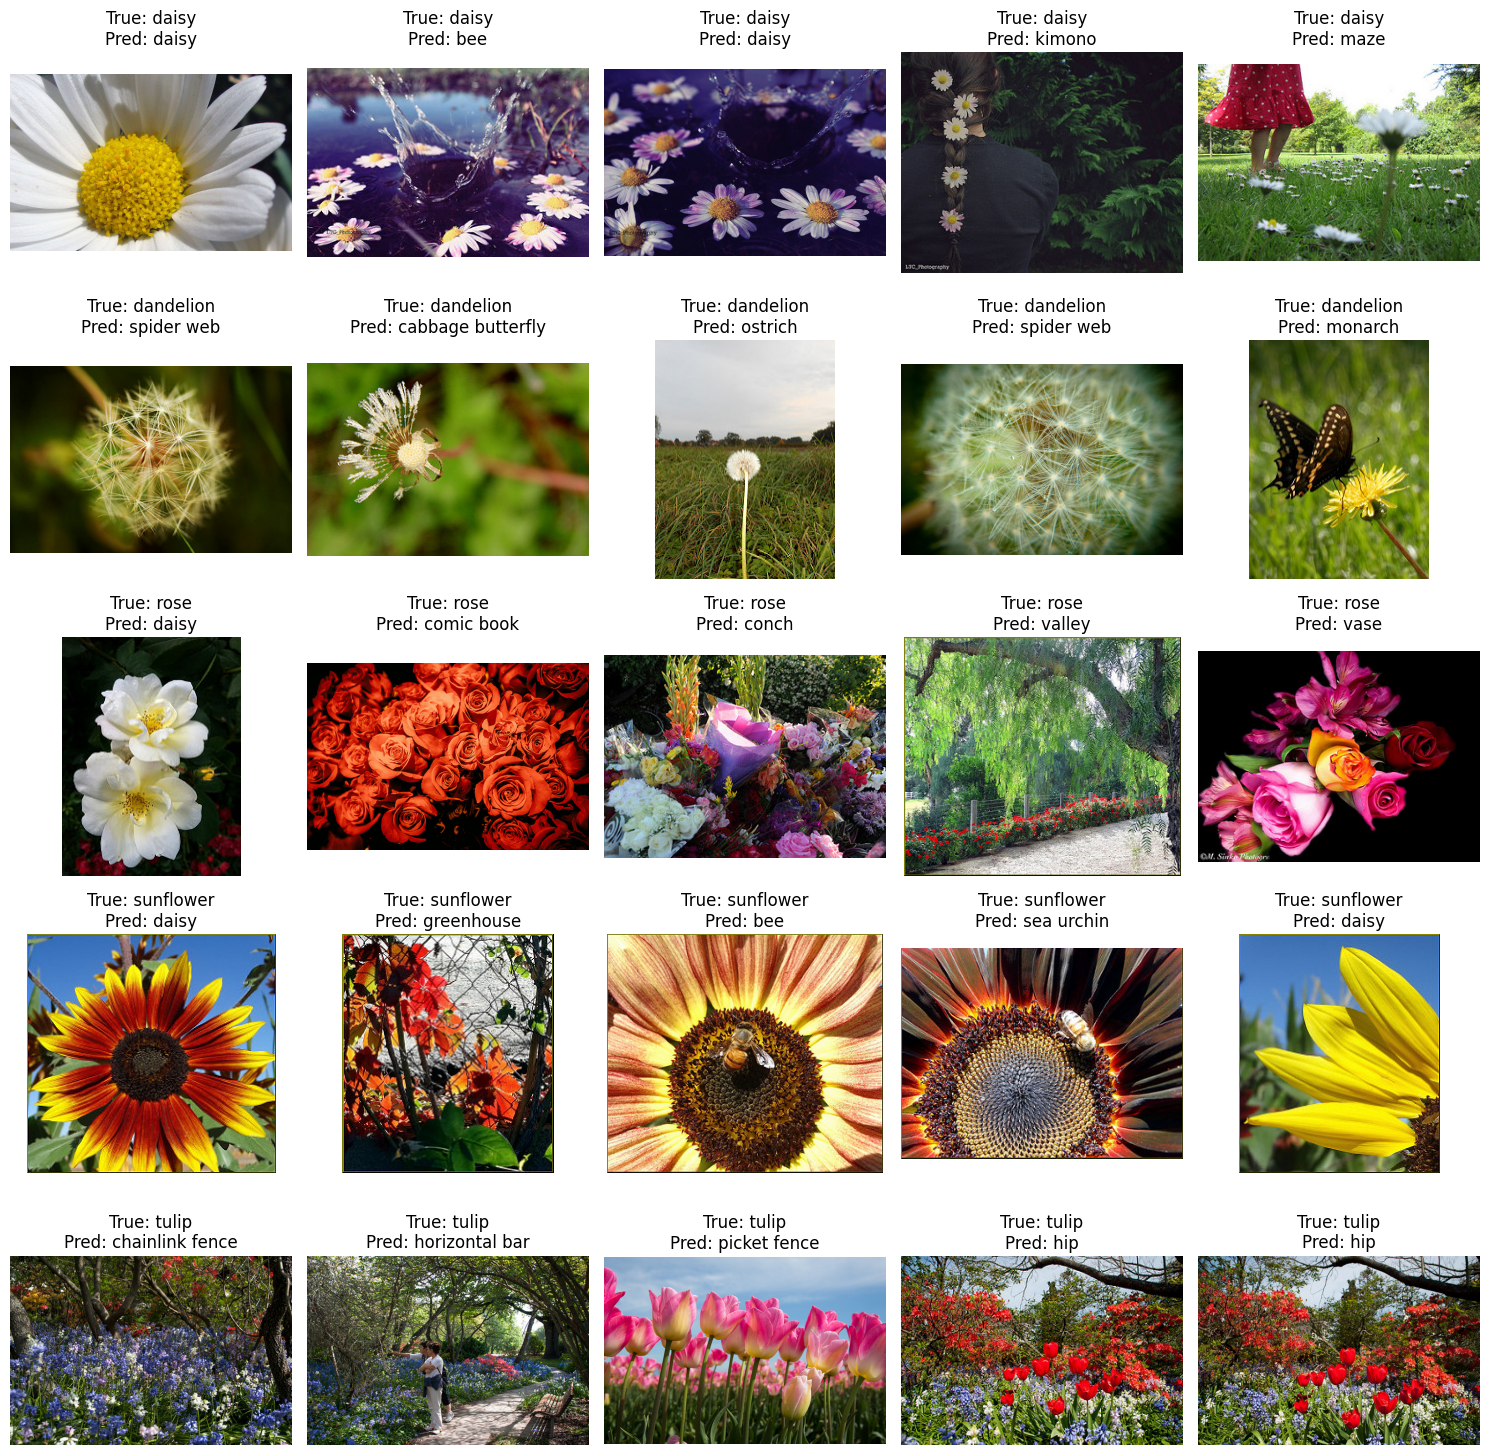

In [3]:
# Create a ResNet18 model and load weights pre-trained on ImageNet.
# Get the imagenet labels and the preprocessing function.
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
imagenet_labels = weights.meta["categories"]
preprocess = weights.transforms()

# Move model to GPU if available.
model = model.to(device)

# Set model to evaluation mode.
model.eval()

# Predict the class of the first n images of each class.
def predict_images_per_class(model, input_df, class_names, pretrain_class_names = None, n=5):
  fig, axes = plt.subplots(len(class_names), n, figsize=(15, 15))
  for i, class_name in enumerate(class_names):
    df = input_df[input_df["label"] == i]
    for j in range(n):
      image_path = df.iloc[j]["path"]
      image = Image.open(image_path)
      input_tensor = preprocess(image).unsqueeze(0).to(device)
      with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        _, top1_catid = torch.topk(probabilities, 1)
        if pretrain_class_names:
          pred_label = pretrain_class_names[top1_catid]
        else:
          pred_label = class_names[top1_catid]

      ax = axes[i, j]
      ax.imshow(image)
      ax.set_title(f"True: {class_name}\nPred: {pred_label}")
      ax.axis('off')
  fig.align_titles()
  plt.tight_layout()
  plt.show()
  
predict_images_per_class(model, dataset_df, dataset.classes, imagenet_labels, 5)

四.使用resnet18模型,修改輸出層為5個類別並推論資料集的所有圖片,計算並顯示出Accuracy和Rank 2 Accuracy(10分)

In [4]:
# Modify the output layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(dataset.classes))

# Move model to GPU if available.
model = model.to(device)

# Set model to evaluation mode.
model.eval()

# Calculate the Accuracy and Rank 2 Accuracy
true_labels = []
top2_pred_labels = []
rank1_correct = 0
rank2_correct = 0

for i, row in tqdm(dataset_df.iterrows(), total=dataset_df.shape[0]):
  true_labels.append(row["label"])
  image_path = row["path"]
  image = Image.open(image_path)
  input_tensor = preprocess(image).unsqueeze(0).to(device)
  with torch.no_grad():
    output = model(input_tensor) 
    prob =  torch.nn.functional.softmax(output, dim=1)
    _, top2_catid = torch.topk(prob, 2)
    top2_pred_labels.append(top2_catid[0].to("cpu").numpy())

for i, l in enumerate(true_labels):
  if l == top2_pred_labels[i][0]:
    rank1_correct += 1
  if l in top2_pred_labels[i]:
    rank2_correct += 1

rank1_accuracy = rank1_correct / len(true_labels)
rank2_accuracy = rank2_correct / len(true_labels)

print(f"Accuracy: {rank1_accuracy:.2f}")
print(f"Rank 2 Accuracy: {rank2_accuracy:.2f}")

100%|██████████| 2746/2746 [00:23<00:00, 118.23it/s]

Accuracy: 0.24
Rank 2 Accuracy: 0.36


五.資料預處理且將資料集分割成80% 訓練集, 10% 驗證集, 10% 測試集(10分)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Split dataset into 80% training, 10% validation, and 10% test
train_df, temp_df = train_test_split(dataset_df, train_size=0.8, stratify=dataset_df["label"], random_state=1017)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=1017)

print("Dataset split")
print("-----------------")
print(f"Training:   {len(train_df)}")
print(f"Validation: {len(valid_df)}")
print(f"Test:       {len(test_df)}")
print("-----------------")
print(f"Total:      {len(dataset_df)}")

# Create a custom dataset class
class CustomImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image = Image.open(row["path"])
    label = row["label"]
    if self.transform:
      image = self.transform(image)
    return image, label

# Create dataloaders for training, validation, and test sets.
# Set the preprocessing function.
batch_size = 128

train_set = CustomImageDataset(train_df, transform=preprocess)
valid_set = CustomImageDataset(valid_df, transform=preprocess)
test_set = CustomImageDataset(test_df, transform=preprocess)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Dataset split
-----------------
Training:   2196
Validation: 275
Test:       275
-----------------
Total:      2746


六:微調resnet18模型,修改輸出層為5個類別並設置learning rate scheduler和Checkpoint -> saving the best model,請顯示出訓練過程,包含每個epoh的Train Accuracy和validation accuracy,以及Checkpoint的狀況(25分)

In [6]:
def train(model, criterion, optimizer, train_loader, valid_loader, device, epochs=10, patience=3):
  best_valid_loss = float('inf')
  patience_counter = 0
  
  model = model.to(device)
  
  for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      predicted = torch.argmax(outputs, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
      for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        predicted = torch.argmax(outputs, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted == labels).sum().item()
    valid_loss /= len(valid_loader)
    valid_accuracy = correct_valid / total_valid
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}, lr: {scheduler.get_last_lr()}")
    
    # Early stopping and Checkpoint saving
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      patience_counter = 0
      torch.save(model, 'best_model.pth')
      print("Saving Checkpoint")
    else:
      patience_counter += 1
      print(f"Patience Counter: {patience_counter}/{patience}")
    if patience_counter >= patience:
      print("Early Stopping")
      break
      

# Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train(model, criterion, optimizer, train_loader, valid_loader, device, epochs=30, patience=5)

Epoch 1/30, Train Loss: 1.0473, Train Accuracy: 0.62, Valid Loss: 0.4668, Valid Accuracy: 0.85, lr: [4e-05]
Saving Checkpoint
Epoch 2/30, Train Loss: 0.3700, Train Accuracy: 0.92, Valid Loss: 0.2985, Valid Accuracy: 0.89, lr: [4e-05]
Saving Checkpoint
Epoch 3/30, Train Loss: 0.2151, Train Accuracy: 0.95, Valid Loss: 0.2373, Valid Accuracy: 0.91, lr: [4e-05]
Saving Checkpoint
Epoch 4/30, Train Loss: 0.1249, Train Accuracy: 0.98, Valid Loss: 0.2063, Valid Accuracy: 0.92, lr: [4e-05]
Saving Checkpoint
Epoch 5/30, Train Loss: 0.0814, Train Accuracy: 0.99, Valid Loss: 0.1865, Valid Accuracy: 0.93, lr: [4e-05]
Saving Checkpoint
Epoch 6/30, Train Loss: 0.0566, Train Accuracy: 1.00, Valid Loss: 0.1833, Valid Accuracy: 0.92, lr: [4e-05]
Saving Checkpoint
Epoch 7/30, Train Loss: 0.0403, Train Accuracy: 1.00, Valid Loss: 0.1685, Valid Accuracy: 0.93, lr: [4e-05]
Saving Checkpoint
Epoch 8/30, Train Loss: 0.0318, Train Accuracy: 1.00, Valid Loss: 0.1700, Valid Accuracy: 0.94, lr: [4e-05]
Patience C

七.顯示出Accuracy和Rank-2 Accuracy(10分)

In [7]:
# Load the best model
model = torch.load('best_model.pth', weights_only=False)
model = model.to(device)
model.eval()

# Calculate the Accuracy and Rank 2 Accuracy on the validation set
def evaluate(model, device, dataloader_name, dataloader):
  true_labels = []
  top2_pred_labels = []
  rank1_correct = 0
  rank2_correct = 0

  for images, labels in dataloader:
    true_labels.extend(labels.tolist())
    images = images.to(device)
    with torch.no_grad():
      output = model(images) 
      prob =  torch.nn.functional.softmax(output, dim=1)
      _, top2_catid = torch.topk(prob, 2)
      top2_pred_labels.extend(top2_catid.to("cpu").numpy())

  for i, l in enumerate(true_labels):
    if l == top2_pred_labels[i][0]:
      rank1_correct += 1
    if l in top2_pred_labels[i]:
      rank2_correct += 1

  rank1_accuracy = rank1_correct / len(true_labels)
  rank2_accuracy = rank2_correct / len(true_labels)

  print(f"{dataloader_name}")
  print(f"Accuracy: {rank1_accuracy:.2f}")
  print(f"Rank 2 Accuracy: {rank2_accuracy:.2f}\n")

evaluate(model, device, "Validation set", valid_loader)
evaluate(model, device, "Test set", test_loader)

Validation set
Accuracy: 0.93
Rank 2 Accuracy: 0.98

Test set
Accuracy: 0.92
Rank 2 Accuracy: 0.98



八.使用微調完的resnet18模型推論測試集每種類別的前五張圖片,顯示出圖片、真實標籤和預測標籤(15分)

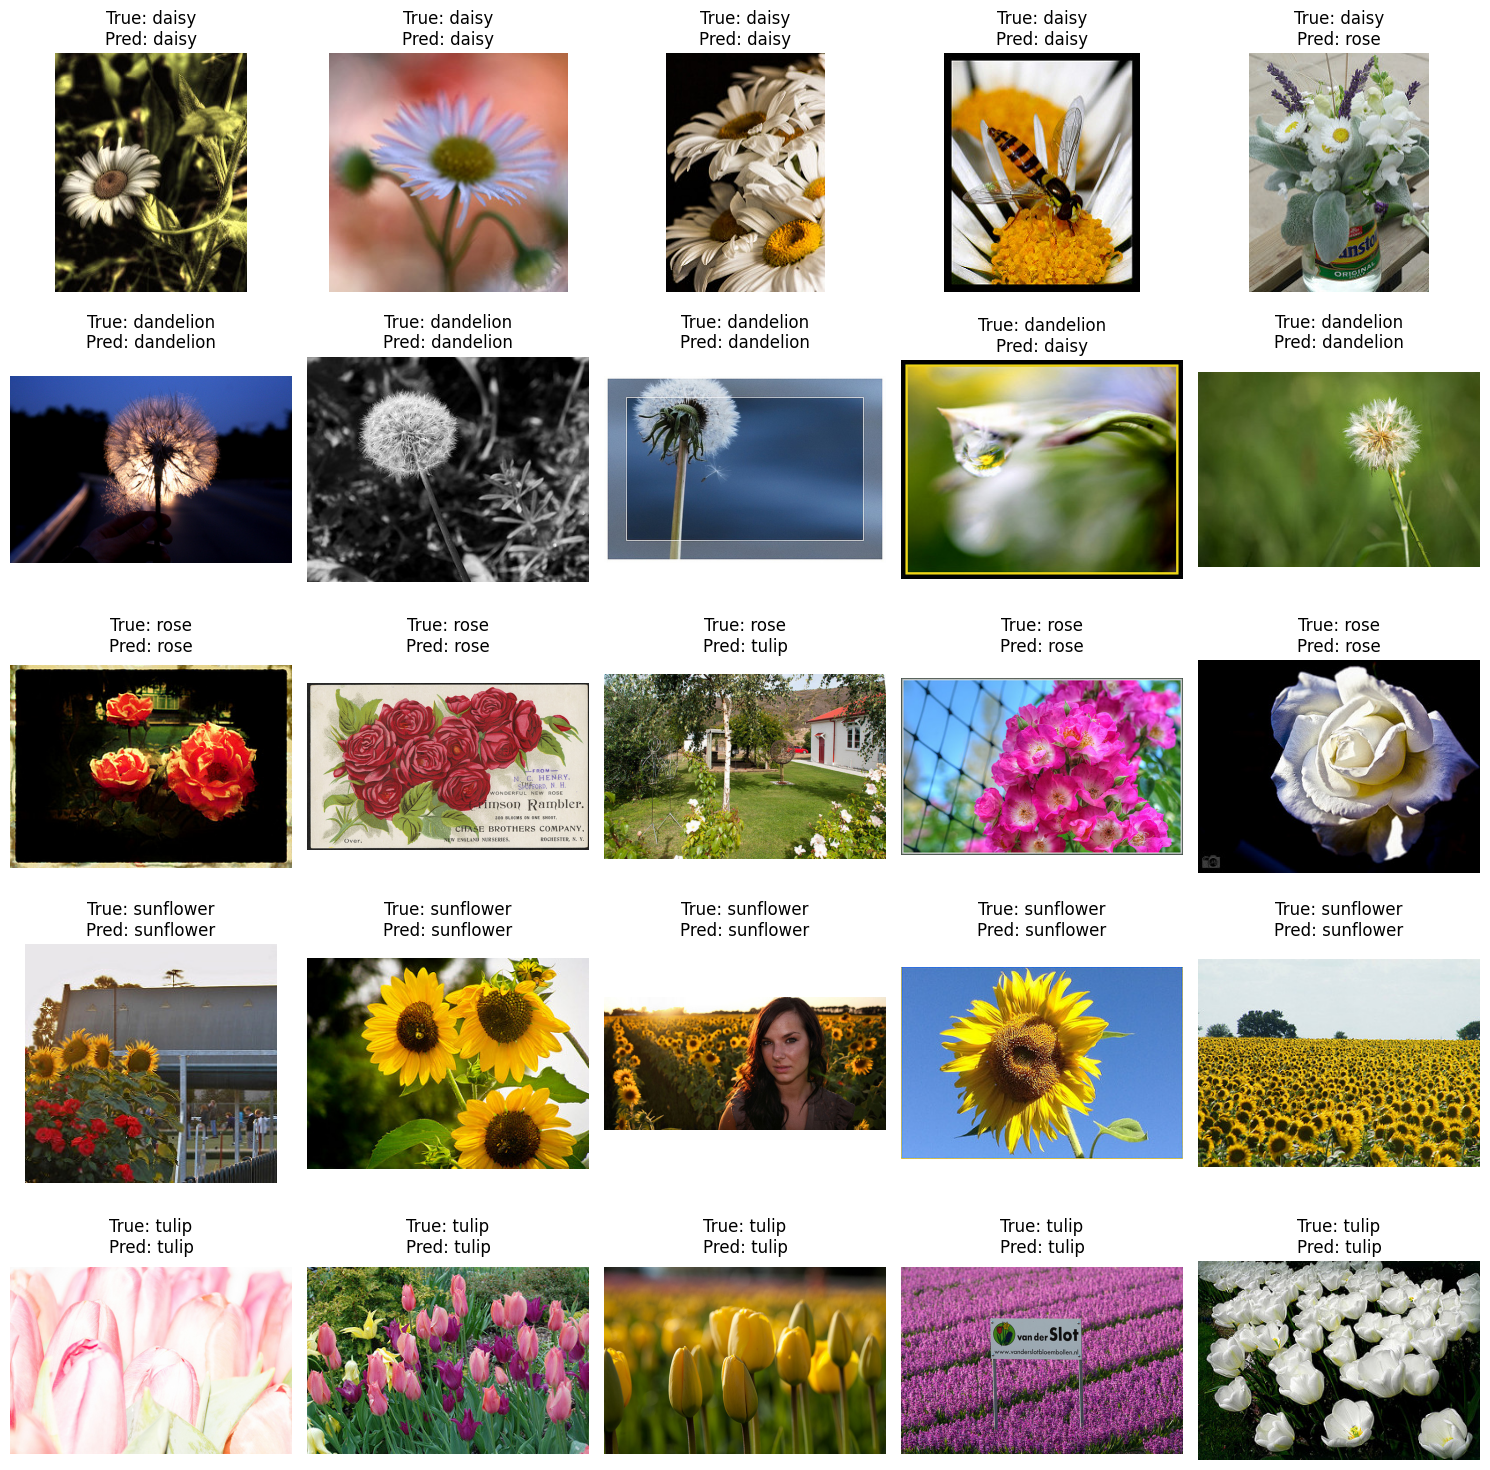

In [8]:
predict_images_per_class(model, test_df, dataset.classes, n=5)